---
title: 3. Colocalizing In-Situ and Satellite Data
authors:
- gwenael_caer
- catherine_schmechtig
---

<hr>

<img src='https://gitlab.ifremer.fr/odatis/vre/tools/frameworks/-/raw/main/img/standard_banner.png' align='right' width='100%' style="margin-bottom: 1rem;"/>

<hr>

```{seealso} Learning outcomes
At the end of this notebook you will know;
* How to <font color="#2367a2">**colocalize**</font> in-situ and satellite data.
```

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="./README.md" target="_blank">README</a>**.

In [1]:
import copernicusmarine
import numpy as np
import pandas as pd
import xarray as xr

## 3.1 Load data

### In-situ data (BGC-Argo)

As seen in notebook #1, we will load the BGC-Argo profile index.

In [2]:
path = "/home/ref-argo/gdac/argo_bio-profile_index.txt"

In [3]:
# Open and format the BGC-ARgo index file
prefix_set = 'BGC_' # dataset prefix
df = pd.read_csv(path, sep=",", header=8)
df['date']= pd.to_datetime(df['date'], format='%Y%m%d%H%M%S')
df['id'] = df['file'].str.split('/').str[1]
df["parameters"] = df["parameters"].str.split()
df = df[df['parameters'].apply(lambda x: 'CHLA' in x)]
df = df.dropna(subset=['longitude', 'latitude', 'id', 'date'])
dataset = xr.Dataset.from_dataframe(df)
dataset = dataset.rename({'index':'obs', 'date':'time'})
dataset = dataset.assign_coords({
    'time': dataset['time'],
    'longitude': dataset['longitude'],
    'latitude': dataset['latitude'],
})
dataset = dataset.rename({var: prefix_set + var for var in dataset.data_vars})
dataset = dataset.rename({coord: prefix_set + coord for coord in dataset.coords if coord != 'obs'})
dataset

<xarray.Dataset> Size: 15MB
Dimensions:                  (obs: 157359)
Coordinates:
    BGC_time                 (obs) datetime64[ns] 1MB 2021-05-06T02:03:16 ......
    BGC_latitude             (obs) float64 1MB 49.24 49.1 48.91 ... 49.03 48.97
    BGC_longitude            (obs) float64 1MB -14.74 -14.62 ... -130.0 -130.1
  * obs                      (obs) int64 1MB 1956 1957 1958 ... 353203 353204
Data variables:
    BGC_file                 (obs) object 1MB 'aoml/1902303/profiles/BD190230...
    BGC_ocean                (obs) object 1MB 'A' 'A' 'A' 'A' ... 'P' 'P' 'P'
    BGC_profiler_type        (obs) int64 1MB 863 863 863 863 ... 834 834 834 834
    BGC_institution          (obs) object 1MB 'AO' 'AO' 'AO' ... 'ME' 'ME' 'ME'
    BGC_parameters           (obs) object 1MB ['PRES', 'TEMP_DOXY', 'PHASE_DE...
    BGC_parameter_data_mode  (obs) object 1MB 'RRRRDRAARARRRRRDRRD' ... 'RRRR...
    BGC_date_update          (obs) int64 1MB 20250625040143 ... 20250619123140
    BGC_id                   (obs) object 1MB '1902303' '1902303' ... '4902691'

### Satellite data (OCEANCOLOUR)

As seen in notebook #2, we will load the OCEANCOLOUR data.

In [6]:
copernicusmarine.login()

INFO - 2025-02-05T15:16:30Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username:

  gcaer2


Copernicus Marine password:

  ········


File /home1/datahome/gcaer/.copernicusmarine/.copernicusmarine-credentials already exists, overwrite it ? [y/N]:

  y


INFO - 2025-02-05T15:16:44Z - Credentials file stored in /home1/datahome/gcaer/.copernicusmarine/.copernicusmarine-credentials.


True

In [10]:
%%time
# Open a single dataset
prefix_cube = 'GLO_' # datacube prefix
chunks = {'time':1, 'longitude':1024, 'latitude':512} # chunksize
datacube = copernicusmarine.open_dataset(
    dataset_id = 'cmems_obs-oc_glo_bgc-plankton_my_l3-multi-4km_P1D',
    service = 'geoseries', 
    chunk_size_limit = 0
)
datacube = datacube.chunk(chunks)
datacube = datacube.rename({var: prefix_cube + var for var in datacube.data_vars})
datacube = datacube.rename({coord: prefix_cube + coord for coord in datacube.coords})
datacube

INFO - 2025-02-05T15:19:47Z - Selected dataset version: "202411"
INFO - 2025-02-05T15:19:47Z - Selected dataset part: "default"


CPU times: user 2.65 s, sys: 92 ms, total: 2.74 s
Wall time: 4.99 s


<xarray.Dataset> Size: 45TB
Dimensions:                  (GLO_time: 10009, GLO_latitude: 4320,
                              GLO_longitude: 8640)
Coordinates:
  * GLO_latitude             (GLO_latitude) float32 17kB -89.98 -89.94 ... 89.98
  * GLO_longitude            (GLO_longitude) float32 35kB -180.0 ... 180.0
  * GLO_time                 (GLO_time) datetime64[ns] 80kB 1997-09-04 ... 20...
Data variables: (12/21)
    GLO_CHL                  (GLO_time, GLO_latitude, GLO_longitude) float32 1TB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    GLO_CHL_uncertainty      (GLO_time, GLO_latitude, GLO_longitude) float64 3TB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    GLO_DIATO                (GLO_time, GLO_latitude, GLO_longitude) float32 1TB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    GLO_DIATO_uncertainty    (GLO_time, GLO_latitude, GLO_longitude) float64 3TB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    GLO_DINO                 (GLO_time, GLO_latitude, GLO_longitude) float32 1TB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    GLO_DINO_uncertainty     (GLO_time, GLO_latitude, GLO_longitude) float64 3TB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    ...                       ...
    GLO_PICO_uncertainty     (GLO_time, GLO_latitude, GLO_longitude) float64 3TB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    GLO_PROCHLO              (GLO_time, GLO_latitude, GLO_longitude) float32 1TB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    GLO_PROCHLO_uncertainty  (GLO_time, GLO_latitude, GLO_longitude) float64 3TB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    GLO_PROKAR               (GLO_time, GLO_latitude, GLO_longitude) float32 1TB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    GLO_PROKAR_uncertainty   (GLO_time, GLO_latitude, GLO_longitude) float64 3TB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    GLO_flags                (GLO_time, GLO_latitude, GLO_longitude) int8 374GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
Attributes:
    institution:  ACRI
    comment:      average
    Conventions:  CF-1.8, ACDD-1.3
    history:      Created using software developed at ACRI-ST
    contact:      servicedesk.cmems@acri-st.fr
    title:        cmems_obs-oc_glo_bgc-plankton_my_l3-multi-4km_P1D
    source:       surface observation
    references:   http://www.globcolour.info GlobColour has been originally f...

## 3.2 Colocalisation

Colocalisation involves identifying data from both in-situ and satellite sources that were acquired at the same time. The existence of similar data from different sources at the same moment allows for the calibration and validation of the data.

In our use case, we aim to calibrate and validate the BGC-Argo data. To do this, we will extract water color satellite product data that coincides with the coordinates of the Argo profiles.

Before we proceed further, let’s define a few terms.

For the remainder of our use case, we will refer to:

* **dataset**: the BGC-Argo profile dataset, sourced from the BGC-Argo index.
* **datacube**: the OCEANCOLOUR satellite product.
* **buffer**: the size in pixels that we wish to extract from our datacube around the coordinates of our profiles.
* **minicube**: the extracted datacube corresponding to our profile, with a size defined by the buffer.

To summarize, we can illustrate the colocalization process with the following diagram:

![colocalisation schema](./_static/colocalisation_schema.png)

### 3.2.1 Pre-processing

Now that the data has been loaded, it needs to be formatted and pre-processed for collocation, in a number of steps.

In [11]:
# Size of minicube to be extracted
buffer = {
    'time': 5,
    'longitude': 2,
    'latitude': 2
}

#### Find the datacube indexes nearest to the observations

the 1st step is to find the indexes in the datacube with the values closest to the observations, so that you know where to extract the data in the datacube

In [12]:
def find_nearest_indices(datacube, dataset, dim) -> xr.DataArray:
    """Find nearest indexes of obs in coords array"""

    coord_array = datacube[prefix_cube + dim].values
    obs_array = dataset[prefix_set + dim].values

    # Trouver les indices d'insertion
    idx = np.searchsorted(coord_array, obs_array)
    
    # Assurer que les indices sont dans les limites
    idx = np.clip(idx, 1, len(coord_array)-1)
    
    # Comparer les valeurs avant et après l'index trouvé
    left = coord_array[idx - 1]
    right = coord_array[idx]
    
    # Trouver quel côté est le plus proche
    idx_nearest = idx - (obs_array - left < right - obs_array)
    
    return xr.DataArray(idx_nearest.astype('int32'), dims=['obs'], coords={'obs': dataset['obs']})

In [13]:
dataset[prefix_set + 'itime'] = find_nearest_indices(datacube, dataset, 'time')
dataset[prefix_set + 'ilongitude'] = find_nearest_indices(datacube, dataset, 'longitude')
dataset[prefix_set + 'ilatitude'] = find_nearest_indices(datacube, dataset, 'latitude')

In [14]:
# Sort observations by increasing time
dataset = dataset.sortby([prefix_set + 'time'])

#### Check that the observations are within the limits of the datacubes.

The 2nd step is to check that the observations are well within the limits of the datacubes. If they exceed the longitude limit, this is not a problem, as we can use modulo 360. 

In [15]:
def in_domain(datacube, dataset, buffer, dim):
    _min = buffer[dim]
    _max = datacube.sizes[prefix_cube + dim] - _min

    def func(values, **kwargs):
        """Checks if values are within a specified range."""
        return np.array([((value >= kwargs['min']) and (value < kwargs['max'])) for value in values])

    return xr.apply_ufunc(
        func, 
        dataset[prefix_set + f'i{dim}'],
        input_core_dims=[[]],
        output_core_dims=[[]],
        output_dtypes=[bool],
        dask='parallelized',
        kwargs={'min': _min, 'max': _max}
    )

In [16]:
# Checks whether the minicube is in the domain (time, lon, lat)
dataset[prefix_set + 'itime_in_domain'] = in_domain(datacube, dataset, buffer, 'time')
dataset[prefix_set + 'ilongitude_in_domain'] = in_domain(datacube, dataset, buffer, 'longitude')
dataset[prefix_set + 'ilatitude_in_domain'] = in_domain(datacube, dataset, buffer, 'latitude')

In [17]:
# Filters out minicubes that are outside the domain for time and lat 
dataset = dataset.where(
    (dataset[prefix_set + 'itime_in_domain'] == True) &
    (dataset[prefix_set + 'ilatitude_in_domain'] == True),
    drop=True
)

#### Create the array of coordinates for the minicubes

In [18]:
def array(dataset, buffer, dim):

    def func(values, **kwargs):
        """Generates an array of ranges centered around each value with a specified buffer."""
        return np.array([np.arange(value - kwargs['buffer'], value + kwargs['buffer'] + 1) for value in values])

    output_core_dims = {
        'time': 't',
        'longitude': 'x',
        'latitude': 'y',
    }

    output_core_dim = output_core_dims[dim]
    return xr.apply_ufunc(
        func, 
        dataset[prefix_set + f'i{dim}'],
        input_core_dims=[[]],
        output_core_dims=[[output_core_dim]],
        output_dtypes=[int],
        dask_gufunc_kwargs=dict(output_sizes={output_core_dim: 2 * buffer[dim] + 1}),
        dask='allowed',
        kwargs={'buffer': buffer[dim]} 
    ).astype('int32')

In [19]:
# Create the i_arrays
dataset[prefix_set + 'itime_array'] = array(dataset, buffer, 'time')
dataset[prefix_set + 'ilongitude_array'] = array(dataset, buffer, 'longitude')
dataset[prefix_set + 'ilatitude_array'] = array(dataset, buffer, 'latitude')

In [20]:
# Modulo longitude index, if longitude above 360 or bellow 0 (not in the domain)
modulo = lambda lon: lon % datacube.sizes[prefix_cube + 'longitude']
dataset[prefix_set + 'ilongitude_array'] = modulo(dataset[prefix_set + 'ilongitude_array']).astype('int32')

In [21]:
float_id = ['5905197'] # Identifiant du flotteur qui nous intéresse
sub = dataset.where(dataset[prefix_set + 'id'].isin(float_id), drop=True)
sub

<xarray.Dataset> Size: 94kB
Dimensions:                   (obs: 300, t: 11, x: 5, y: 5)
Coordinates:
    BGC_time                  (obs) datetime64[ns] 2kB 2017-04-17T07:15:57 .....
    BGC_latitude              (obs) float64 2kB -35.59 -35.59 ... -36.69 -36.69
    BGC_longitude             (obs) float64 2kB 131.8 131.8 ... 104.9 104.9
  * obs                       (obs) int64 2kB 285891 285892 ... 286189 286190
Dimensions without coordinates: t, x, y
Data variables: (12/17)
    BGC_file                  (obs) object 2kB 'csiro/5905197/profiles/BD5905...
    BGC_ocean                 (obs) object 2kB 'I' 'I' 'I' 'I' ... 'I' 'I' 'I'
    BGC_profiler_type         (obs) float64 2kB 869.0 869.0 ... 869.0 869.0
    BGC_institution           (obs) object 2kB 'CS' 'CS' 'CS' ... 'CS' 'CS' 'CS'
    BGC_parameters            (obs) object 2kB ['PRES', 'DOXY', 'TEMP_DOXY', ...
    BGC_parameter_data_mode   (obs) object 2kB 'RDRRRARRRRRRRRRRRRRR' ... 'RA...
    ...                        ...
    BGC_itime_in_domain       (obs) float64 2kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    BGC_ilongitude_in_domain  (obs) float64 2kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    BGC_ilatitude_in_domain   (obs) float64 2kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    BGC_itime_array           (obs, t) float64 26kB 7.16e+03 ... 8.022e+03
    BGC_ilongitude_array      (obs, x) float64 12kB 7.48e+03 ... 6.839e+03
    BGC_ilatitude_array       (obs, y) float64 12kB 1.303e+03 ... 1.281e+03

In [29]:
sub = dataset.where(
    (dataset[prefix_set + 'time'] >= np.datetime64("2020-01-01")) & 
    (dataset[prefix_set + 'time'] <= np.datetime64("2020-02-01")), 
    drop=True
).isel(obs=slice(0, 25))
sub

<xarray.Dataset> Size: 8kB
Dimensions:                   (obs: 25, t: 11, x: 5, y: 5)
Coordinates:
    BGC_time                  (obs) datetime64[ns] 200B 2020-01-01T02:55:02 ....
    BGC_latitude              (obs) float64 200B -42.8 17.18 ... -31.06 37.27
    BGC_longitude             (obs) float64 200B -17.99 -20.63 ... -2.923 162.8
  * obs                       (obs) int64 200B 74281 247049 ... 80979 260293
Dimensions without coordinates: t, x, y
Data variables: (12/17)
    BGC_file                  (obs) object 200B 'aoml/5904982/profiles/BD5904...
    BGC_ocean                 (obs) object 200B 'A' 'A' 'I' 'A' ... 'P' 'A' 'P'
    BGC_profiler_type         (obs) float64 200B 846.0 846.0 ... 846.0 841.0
    BGC_institution           (obs) object 200B 'AO' 'IF' 'IF' ... 'AO' 'HZ'
    BGC_parameters            (obs) object 200B ['PRES', 'TEMP_DOXY', 'TPHASE...
    BGC_parameter_data_mode   (obs) object 200B 'RRRDRAARARRRRRDRRD' ... 'RRR...
    ...                        ...
    BGC_itime_in_domain       (obs) float64 200B 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    BGC_ilongitude_in_domain  (obs) float64 200B 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    BGC_ilatitude_in_domain   (obs) float64 200B 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    BGC_itime_array           (obs, t) float64 2kB 8.149e+03 ... 8.16e+03
    BGC_ilongitude_array      (obs, x) float64 1kB 3.886e+03 ... 8.229e+03
    BGC_ilatitude_array       (obs, y) float64 1kB 1.13e+03 ... 3.056e+03

### 3.2.2 Extract minicubes

We'll use numpy's vector indexing functionality to extract all the minicubes in one go. 

In [30]:
%%time
minicube = datacube.isel(**{
    prefix_cube + 'time': sub[prefix_set + 'itime_array'].astype('int32'),
    prefix_cube + 'longitude': sub[prefix_set + 'ilongitude_array'].astype('int32'),
    prefix_cube + 'latitude': sub[prefix_set + 'ilatitude_array'].astype('int32'),
})

CPU times: user 832 ms, sys: 0 ns, total: 832 ms
Wall time: 830 ms


### 3.2.3 Post-processing 

In [31]:
minicube = minicube.transpose('obs', 't', 'x', 'y', ...)
minicube[prefix_set + 'time'] = minicube[prefix_set + 'time'].astype('datetime64[ns]')
minicube[prefix_cube + 'time'] = minicube[prefix_cube + 'time'].astype('datetime64[ns]')

### 3.2.4 Computation

In [32]:
%%time
minicube = minicube.compute()

CPU times: user 1min 5s, sys: 3.56 s, total: 1min 8s
Wall time: 1min 34s


## 3.3 Visualize  data

In [33]:
minicube

<xarray.Dataset> Size: 836kB
Dimensions:                  (obs: 25, t: 11, x: 5, y: 5)
Coordinates:
    GLO_latitude             (obs, y) float32 500B -42.9 -42.85 ... 37.31 37.35
    GLO_longitude            (obs, x) float32 500B -18.06 -18.02 ... 162.9 162.9
    GLO_time                 (obs, t) datetime64[ns] 2kB 2019-12-27 ... 2020-...
    BGC_time                 (obs) datetime64[ns] 200B 2020-01-01T02:55:02 .....
    BGC_latitude             (obs) float64 200B -42.8 17.18 ... -31.06 37.27
    BGC_longitude            (obs) float64 200B -17.99 -20.63 ... -2.923 162.8
  * obs                      (obs) int64 200B 74281 247049 ... 80979 260293
Dimensions without coordinates: t, x, y
Data variables: (12/21)
    GLO_CHL                  (obs, t, x, y) float32 28kB nan nan nan ... nan nan
    GLO_CHL_uncertainty      (obs, t, x, y) float64 55kB nan nan nan ... nan nan
    GLO_DIATO                (obs, t, x, y) float32 28kB nan nan nan ... nan nan
    GLO_DIATO_uncertainty    (obs, t, x, y) float64 55kB nan nan nan ... nan nan
    GLO_DINO                 (obs, t, x, y) float32 28kB nan nan nan ... nan nan
    GLO_DINO_uncertainty     (obs, t, x, y) float64 55kB nan nan nan ... nan nan
    ...                       ...
    GLO_PICO_uncertainty     (obs, t, x, y) float64 55kB nan nan nan ... nan nan
    GLO_PROCHLO              (obs, t, x, y) float32 28kB nan nan nan ... nan nan
    GLO_PROCHLO_uncertainty  (obs, t, x, y) float64 55kB nan nan nan ... nan nan
    GLO_PROKAR               (obs, t, x, y) float32 28kB nan nan nan ... nan nan
    GLO_PROKAR_uncertainty   (obs, t, x, y) float64 55kB nan nan nan ... nan nan
    GLO_flags                (obs, t, x, y) int8 7kB 0 0 0 0 0 0 ... 0 0 0 0 0 0
Attributes:
    institution:  ACRI
    comment:      average
    Conventions:  CF-1.8, ACDD-1.3
    history:      Created using software developed at ACRI-ST
    contact:      servicedesk.cmems@acri-st.fr
    title:        cmems_obs-oc_glo_bgc-plankton_my_l3-multi-4km_P1D
    source:       surface observation
    references:   http://www.globcolour.info GlobColour has been originally f...

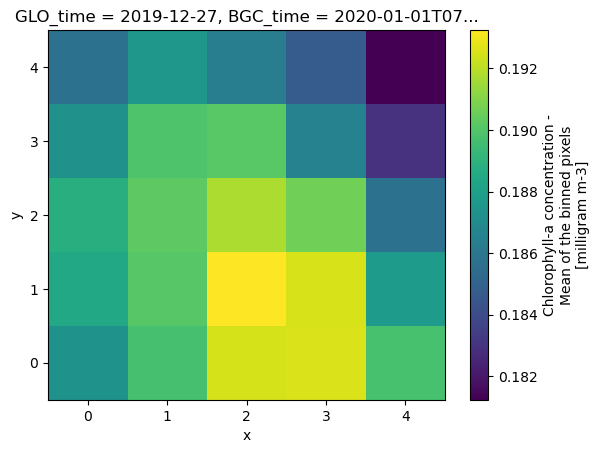

In [34]:
minicube.isel(obs=4, t=0).GLO_CHL.plot(x='x', y='y', cmap='viridis')

In [41]:
print(f"Minicube size: {minicube.nbytes / (1024 ** 2)} Mb")

Minicube size: 0.7971525192260742 Mb
